## 🎯#1. 실습 : RDKit을 이용함


RDKit,SMILES 라이브러리와 DeepChem 데이터를 사용하여 분자 구조를 벡터화하고 QSAR 예측 모델을 만들어 생명과학에 쓰이는 머신러닝을 실습해보았습니다.
- 분자 구조(SMILES)를 벡터화하는 법
- 머신러닝으로 약물 활성 여부 예측
- 딥러닝 모델과 결과 비교


### 🙏 참고한 자료
- [The RDKit Documentation](https://www.rdkit.org/docs/)
- [deepchem -- MoleculeNet](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html)

정확도: 96.49%
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



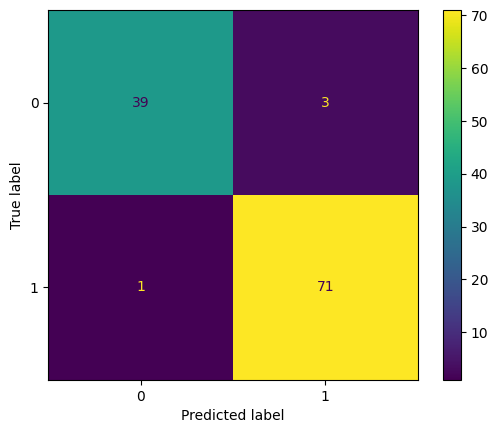

<Figure size 640x480 with 0 Axes>

In [2]:
# 예제 데이터
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# 예제 데이터 학습 및 평가
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("정확도: {:.2f}%".format(accuracy*100))
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
plt.savefig("image/breast_cancer__lr.png")

np.save("data/X_train_bc.npy", X_train)
np.save("data/X_test_bc.npy", X_test)
np.save("data/y_train_bc.npy", y_train)
np.save("data/y_test_bc.npy", y_test)
np.save("data/X_features_bc.npy", X)
np.save("data/y_labels_bc.npy", y)

| 실제\예측 | 예측=악성(0) | 예측=양성(1) |
| -- | -- | -- |
| **실제=악성(0)** | TP (진짜 환자를 환자로 예측) | FN (환자인데 정상이라고 예측)  |
| **실제=양성(1)** | FP (정상인데 환자라고 예측)  | TN (진짜 정상을 정상으로 예측) |

*TP : True Positive
*FN : False Negative

In [19]:
# !pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.3 MB/s eta 0:00:00a 0:00:01


In [25]:
import numpy as np
import pandas as pd
from deepchem.molnet import load_hiv,load_tox21 #deepchem 내의 표준분자 데이터셋 모음집 molnet. 유명한 약물 및 단백질 데이터셋 이용가능
from rdkit import Chem
from rdkit.Chem import DataStructs
from sklearn.ensemble import RandomForestClassifier #의사결정나무를 여러개 조합한 모델. 분류문제에서 튜닝 없이도 잘동작. 변수 중요도 해석가능. 큰 데이터셋도 빠르게 학습가능
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from rdkit.Chem import rdFingerprintGenerator


# 1. 데이터 전처리
# HIV 억제 약물 예픅 데이터셋 로드
task, datasets, transformers = load_hiv(featurizer='Raw', splitter='random')
    #load_tox21()등 다양한 데이터셋 이용가능. y=1 약물활성 있음. y=0 없음
    # featurizer='Raw'로 문자열 그대로 받아서 벡터화는 직접함. 'ECFP'는 자동 벡터화함
    # #split='random'데이터를 랜덤으로 훈련/검증/테스트용으로 나눠줌
train_dataset, valid_dataset, test_dataset = datasets
    # 훈련/검증/테스트용으로 나눠진 dataset 튜플을 각각 변수에 지정함

X_smiles = np.concatenate([train_dataset.ids, valid_dataset.ids, test_dataset.ids]).flatten()
y = np.concatenate([train_dataset.y, valid_dataset.y, test_dataset.y])

# NaN 라벨 제거
mask = ~np.isnan(y).flatten()#NaN이 아닌(~) 값만 True 로 반환. 2차원으로 반환하기 때문에 flatten() 을 해줌. 
X_smiles = X_smiles[mask]#문자열로 표현된 분자구조 리스트
y = y[mask].astype(int)

# 2. smiles 분자구조를 문자열에서 벡터로 변환 
# SMILES → Morgan fingerprint
def featurize_smiles(smiles_list):
    features = []#벡터화한 값을 넣을 결과 리스트
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        #radius=2 : fingerprint를 만들 때 원자 주변 몇 bond까지 볼지 설정. 일반적으로 2~3이 자주 사용됨
        #fpSize=2048 : 생성할 bit 벡터의 길이. 2048은 딱 256바이트를 쓸 수 있어 잘 쓰임. 2048이면 대부분의 500Da(Dalton)이하의 약물 분자 크기에 충분함
        #즉, gen은 원자 주변 2bond 까지 보는 2048 비트의 fingerprint 생성기
    for smi in smiles_list:
        #smile 문자열을 분자로 변환
        mol = Chem.MolFromSmiles(smi)
        # fallback
        if mol is None:#smiles정보가 잘못된경우, MolFromSmiles은 None 을 반환
            features.append(np.zeros(2048))  #2048개의 0으로 리스트를 채워 벡터 반환
            continue
        fp = gen.GetFingerprint(mol)#fp는 rdkit 의 고유 포맷이라, 머신러닝에 쓸 수 없음
        arr = np.zeros((2048,))#2048개의 0이 있는 벡터
        DataStructs.ConvertToNumpyArray(fp, arr)#bit vector 를 numpy의 array 로 복사시켜, 머신러닝에 쓸 수 있는 형태로 변환
        features.append(arr)#완성된 어레이를 결과 리스트에 추가
    return np.array(features)

X_features = featurize_smiles(X_smiles)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, stratify=y, random_state=42)


[22:00:48] WARNING: not removing hydrogen atom without neighbors
[22:00:48] Explicit valence for atom # 8 Al, 6, is greater than permitted
Failed to featurize datapoint 1322, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[22:00:48] Explicit valence for atom # 3 Al, 6, is greater than permitted
Failed to featurize datapoint 2290, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[22:00:48] Explicit valence for atom # 4 Al, 6,

IndexError: boolean index did not match indexed array along axis 0; size of axis is 7823 but size of corresponding boolean axis is 93876

In [24]:
np.save("data/X_train_tox21.npy", X_train)
np.save("data/X_test_tox21.npy", X_test)
np.save("data/y_train_tox21.npy", y_train)
np.save("data/y_test_tox21.npy", y_test)
np.save("data/X_features_tox21.npy", X_features)
np.save("data/y_labels_tox21.npy", y)

In [12]:
# 3. 머신러닝 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


/Users/jiwonju/anaconda3/envs/qml1w/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

정확도: 97.30%


,precision,recall,f1-score,support
0,0.975,0.997,0.986,7935.000
1,0.796,0.311,0.448,289.000
accuracy,0.973,0.973,0.973,0.973
macro avg,0.886,0.654,0.717,8224.000
weighted avg,0.969,0.973,0.967,8224.000


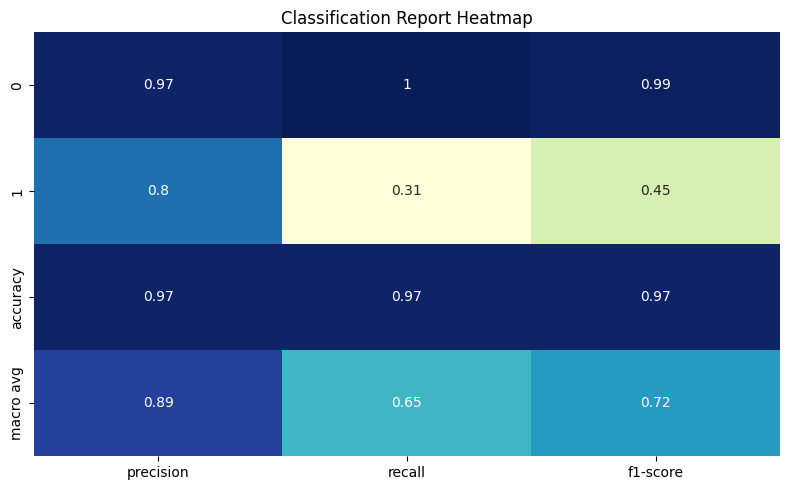

In [13]:
# 4. 성능 평가
import seaborn as sns

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("정확도: {:.2f}%".format(accuracy*100))

report_dict = classification_report(y_test, y_pred,output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().round(3)
display(df_report)
# 'support'는 숫자 범위가 달라서 제외
df_plot = df_report.drop(columns=['support'], errors='ignore')
# 히트맵 그리기
plt.figure(figsize=(8, 5))
sns.heatmap(df_plot.iloc[:-1], annot=True, cmap="YlGnBu", cbar=False)
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.savefig("ML_classification_report_heatmap.png", dpi=300)
plt.show()
df_report.to_csv("ML_creport.csv")



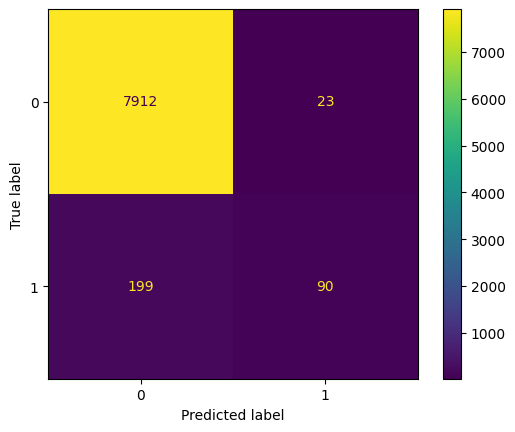

<Figure size 640x480 with 0 Axes>

In [14]:
# confusion matrix 평가
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
plt.savefig("image/hiv_ML_RFC.png")

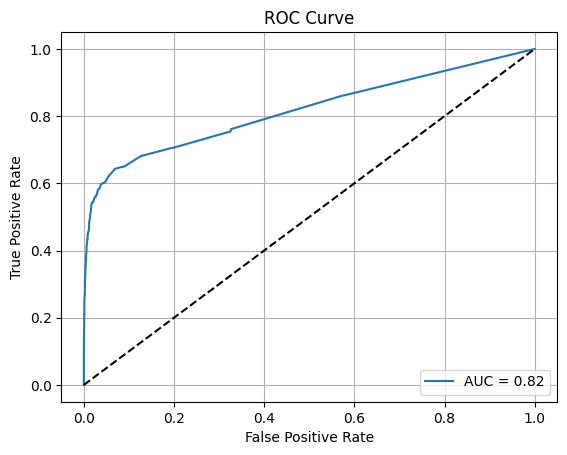

In [15]:
from sklearn.metrics import roc_curve, auc
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # 랜덤 분류 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("image/ML_roc_curve.png", dpi=300)
plt.show()


In [65]:
# 새로운 분자에 예측 해보기
new_smiles = ["CC(=O)OC1=CC=CC=C1C(=O)O", "CCO", "c1ccccc1N"]
X_new = featurize_smiles(new_smiles)
y_new_pred = model.predict(X_new)
print(y_new_pred)
print(list(zip(new_smiles, y_new_pred)))

[0 0 0]
[('CC(=O)OC1=CC=CC=C1C(=O)O', np.int64(0)), ('CCO', np.int64(0)), ('c1ccccc1N', np.int64(0))]


## ✍️ 배운 점
- 

## 📌 다음 목표
- QML (양자 커널 분류기)로 확장
- 또는 Qiskit 기반 양자 커널 SVM에 연결 

## 💭궁금한 점 및 추가 정보
#### 1. bit vector 란?
0과 1만 있는 벡터

#### 2. smile 의 fingerprint 란?
분자 구조를 0과 1의 벡터로 표현한것.
벤젠 고리, OH기 등 모두 0,1로 표현하고 있음.

| 부분구조 | 해시값      | index (mod 2048) | 벡터                 |
| ---- | -------- | ---------------- | ------------------ |
| 벤젠고리 | 73542342 | 314              | 1 at position 314  |
| OH기  | 98323123 | 1202             | 1 at position 1202 |
| NH기  | 77192812 | 982              | 1 at position 982  |

```text
[0, 0, 0, ..., 0, 1, 0, ..., 0, 1, 0, ..., 1, 0]
                   ↑         ↑         ↑
                 314      982      1202

```

#### 3. ravel vs flatten 차이점?
 
| | 반환 | 설명 |예시|
|--| -- | -- | -- |
| ravel | **뷰(view)**  | 원본 데이터를 가리키는 **"얇은 껍데기"** → 값을 바꾸면 원본도 바뀜 |b = a[1:4];b[0] = 999;→a 값 변환, b=mask.ravel();b[..]=False;→mask값 변환|
| flatten | **복사(copy)** | 원본 데이터를 **통째로 복사한 새 배열** → 바꿔도 원본에는 영향 없음 |b = a[1:4].copy();→b값 변화시켜도 a 값은 그대로. b=mask.flatten();→mask값 그대로|


#### 4. Da = Dalton
1Da = 1u(원자질량 단위,약 수소 원자 하나의 질량) = 1g/mol
* 경구약물로 적합한 조건 중 하나 : 분자량 < 500Da



##### 5. X_features 와 fp의 형태 확인
```python
print(X_features)

gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

mol = Chem.MolFromSmiles("CCO")
fp = gen.GetFingerprint(mol)  # <- 여기에 분자 넣어서 벡터 생성
print(fp)
print(type(fp))
----------
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x16c120820>
<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>

```

#### 6. 결과해석 방법
Precision: 예측이 맞다고 한 것 중 실제 맞은 비율
$Precision = \frac{TP}{TP+FP}$
Recall: 실제 맞은 것 중 예측에 성공한 비율
F1-score: 두 지표의 균형

## 🏁에러디버깅
#### 1. 에러 : `IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed`

---> 21 X_smiles = X_smiles[mask]
```python
y = np.array([1.0, np.nan, 0.0, 1.0])
print(mask)
y= y[mask]
print(y)
```
#문제점: mask 값이 [[True, ... ]]형태의 2차원으로 반환됨   
#해결법: mask를 flatten, ravel로 1차원화 해주기

#### 2. warning 대응 : `[15:18:18] DEPRECATION WARNING: please use MorganGenerator`
#문제점 : GetMorganFingerprintAsBitVect이 새로운 버전에서 없어질 예정임    
#해결법 : GetMorganFingerprintAsBitVect 대신 MorganGenerator 사용.


기존 코드
```python
from rdkit.Chem import AllChem,
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
```
↓
변경 후
```python
from rdkit.Chem import rdFingerprintGenerator
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
...
        fp = gen.GetFingerprint(mol)#, 2, nBits=2048
```

- 참고 : [RDKit blog- FingerprintGenerator tutorial](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html)